In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('C:\\Users\\joewa\\Work\\git\\vimms')
sys.path.append('C:\\Users\\Vinny\\work\\vimms')
sys.path.append('..')

In [3]:
import numpy as np
import torch
import random as rand
import pylab as plt
import multiprocessing
from gym import spaces

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_checker import check_env

In [4]:
from vimms.Common import *
from vimms.Gym import VimmsGymEnv
from vimms.Evaluation import evaluate_simulated_env, evaluate_multiple_simulated_env
from vimms.ChemicalSamplers import MZMLFormulaSampler, MZMLRTandIntensitySampler

In [5]:
np.random.seed(0)
rand.seed(0)
torch.manual_seed(0)

# 1. Parameters

In [6]:
set_log_level_warning()

1

In [7]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (0, 300)
# intensity_range = (1E5, 1E10)

In [8]:
# n_chemicals = (500, 2000)
# mz_range = (100, 600)
# rt_range = (200, 1000)
# intensity_range = (1E5, 1E10)

In [9]:
n_chemicals = (200, 500)
mz_range = (100, 600)
rt_range = (200, 1000)
intensity_range = (1E5, 1E10)

In [10]:
min_mz = mz_range[0]
max_mz = mz_range[1]
min_rt = rt_range[0]
max_rt = rt_range[1]
min_log_intensity = np.log(intensity_range[0])
max_log_intensity = np.log(intensity_range[1])

In [11]:
isolation_window = 0.7
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 5000
ionisation_mode = POSITIVE
noise_density = 0.3
noise_max_val = 1e4

In [12]:
in_dim = 25
out_dim = 10

# 2. Define Custom gym

In [13]:
mzml_filename = 'Beer_multibeers_1_fullscan1.mzML'
mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                       min_log_intensity=min_log_intensity,
                                       max_log_intensity=max_log_intensity)

In [14]:
params = {
    'chemical_creator': {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
    },
    'noise': {
        'noise_density': noise_density,
        'noise_max_val': noise_max_val,
        'mz_range': mz_range
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'N': N,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
        'min_ms1_intensity': min_ms1_intensity
    }
}

In [15]:
class MaxIntensityEnv(VimmsGymEnv):
    def __init__(self, in_dim, out_dim, params):
        super().__init__(in_dim, out_dim, params)    
    
    def _get_action_space(self):
        """
        Defines action space
        """
        return spaces.Discrete(self.out_dim)

    def _get_observation_space(self):
        """
        Defines observation space
        """
        lower = np.float32(np.array([0.0] * self.in_dim))
        upper = np.float32(np.array([np.inf] * self.in_dim))
        return spaces.Box(lower, upper)
    
    def _get_state(self, scan_to_process):
        """
        Converts a scan to a state
        """
        mzs, rt, intensities = self._get_mzs_rt_intensities(scan_to_process)
        included_intensities = []
        for mz, intensity in zip(mzs, intensities):
            if self.controller.exclusion.is_excluded(mz, rt):
                continue
            included_intensities.append(intensity)
        included_intensities = np.array(included_intensities)

        sorted_intensities = sorted(included_intensities, reverse=True)
        features = np.log(sorted_intensities[0:25])
        
        for i in range(len(features)):
            if np.isnan(features[i]): features[i] = 0
        return features   
    
    def _compute_reward(self, scan_to_process, results):
        """
        Computes fragmentation reward
        """
        parent_scan_id = self.controller.last_ms1_scan.scan_id
        assert scan_to_process.scan_id == parent_scan_id
        total_reward = 0.0
        for ms2_scan in results:
            assert ms2_scan.ms_level == 2            
            precursor = ms2_scan.scan_params.get(ScanParameters.PRECURSOR_MZ)[0]
            intensity = precursor.precursor_intensity
            reward = np.log(intensity)
            total_reward += reward                
        return total_reward    

    def _take_action(self, action):
        """
        Modify controller variables based on the selected action
        """
        # assume 10 action space
        # TODO: would be good to have some kind of interface for this??

        if action < 0:
            self.seen_actions.update(['N=%d' % self.controller.N])
            self.seen_actions.update(['DEW=%.1f' % self.controller.rt_tol])
        elif 0 <= action < 5:
            self.controller.N = (action + 1) * 5  # N = {5, 10, 15, 20, 25}
            self.seen_actions.update(['N=%d' % self.controller.N])
        elif 5 <= action < 10:
            self.controller.rt_tol = (action - 5 + 1) * 5  # rt_tol = {5, 10, 15, 20, 25}
            self.seen_actions.update(['DEW=%.1f' % self.controller.rt_tol])

#         if action >= 0:
#             self.controller.N = action+1
#         self.seen_actions.update(['N=%d' % self.controller.N])

In [16]:
set_log_level_info()

2

# 3. Training

### DQN

In [17]:
env = MaxIntensityEnv(in_dim, out_dim, params)
check_env(env)

In [18]:
model_name = 'DQN'
model = DQN("MlpPolicy", env, exploration_fraction=0.25, exploration_initial_eps=1.0, exploration_final_eps=0.10, tensorboard_log='./results/%s_MaxIntensityEnv_tensorboard' % model_name)
model.learn(total_timesteps=250000)

In [19]:
fname = 'results/%s_maxintensity_smallchems' % model_name
model.save(fname)

# 4. Evaluation

In [20]:
model_name = 'DQN'
fname = 'results/%s_maxintensity_smallchems' % model_name
model = DQN.load(fname)

In [21]:
num_episodes = 100
write_mzml_every = 10

In [22]:
chems_list = []
for i in range(num_episodes):
    env = MaxIntensityEnv(in_dim, out_dim, params)
    env.reset()
    chems = env.chems
    print(len(chems))
    chems_list.append(chems)

415
401
421
253
435
436
282
286
374
442
410
281
345
457
257
388
376
273
383
442
465
227
300
331
290
498
366
351
394
221
349
482
420
217
410
337
392
306
377
268
267
256
382
284
215
420
495
403
437
238
239
417
478
483
270
286
278
306
284
316
215
468
269
452
382
347
371
260
409
334
281
375
456
369
472
274
392
484
356
320
393
377
399
441
461
356
409
408
250
278
275
202
498
464
254
304
462
256
336
286


In [49]:
def evaluation(model, model_name, in_dim, out_dim, params, num_episodes, chems_list):
    env = MaxIntensityEnv(in_dim, out_dim, params)
    total_rewards = []
    total_reward_per_chems = []
    env_list = []
    
    for i_episode in range(num_episodes):
        chems = chems_list[i_episode]
        observation = env.reset(chems=chems)
        total_reward = 0
        for t in range(1000):
            # env.render()
            if model_name == 'random':
                action = env.action_space.sample()
                out_file = 'test_%s_%d.mzML' % ('random', i_episode)
            elif model_name == 'TopN':
                action = -1
                out_file = 'test_%s_%d.mzML' % ('TopN', i_episode)                
            else:
                action, _ = model.predict(observation, deterministic=False)     
                out_file = 'test_%s_%d.mzML' % (model_name, i_episode)
                                                
            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                seen_actions = env.seen_actions.most_common()
                n_chems = len(env.chems)
                reward_per_chems = total_reward / n_chems
                total_rewards.append(total_reward)
                total_reward_per_chems.append(reward_per_chems)
                env_list.append(env.vimms_env)
                if i_episode % write_mzml_every == 0 or i_episode == num_episodes-1:
                    print('Episode %d timesteps %d reward %f n_chems %d reward/chems %f actions %s' % (i_episode, t+1, total_reward, n_chems, reward_per_chems, seen_actions))                    
                    env.vimms_env.write_mzML('results', out_file)
                else:
                    print('Episode %d timesteps %d reward %f n_chems %d reward/chems %f' % (i_episode, t+1, total_reward, n_chems, reward_per_chems))                                        
                break
    env.close()
    print('Average total reward = %f' % np.mean(total_rewards))
    return np.array(total_rewards), np.array(total_reward_per_chems), env_list

In [50]:
model_total_rewards, model_reward_per_chems, model_env_list = evaluation(model, model_name, in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 152 reward 43520.792786 n_chems 415 reward/chems 104.869380 actions [('N=25', 139), ('DEW=15.0', 3), ('DEW=10.0', 3), ('N=10', 2), ('DEW=25.0', 2), ('N=20', 2), ('N=5', 1)]
Episode 1 timesteps 149 reward 42921.858248 n_chems 401 reward/chems 107.037053
Episode 2 timesteps 151 reward 43359.130663 n_chems 421 reward/chems 102.990809
Episode 3 timesteps 153 reward 39740.447549 n_chems 253 reward/chems 157.076868
Episode 4 timesteps 151 reward 42915.898135 n_chems 435 reward/chems 98.657237
Episode 5 timesteps 153 reward 43975.055870 n_chems 436 reward/chems 100.860220
Episode 6 timesteps 151 reward 43488.413175 n_chems 282 reward/chems 154.214231
Episode 7 timesteps 152 reward 40052.993396 n_chems 286 reward/chems 140.045431
Episode 8 timesteps 151 reward 44177.297172 n_chems 374 reward/chems 118.121115
Episode 9 timesteps 150 reward 42320.973979 n_chems 442 reward/chems 95.748810
Episode 10 timesteps 151 reward 42529.221183 n_chems 410 reward/chems 103.729808 actions 

In [25]:
random_total_rewards, random_reward_per_chems, random_env_list = evaluation(None, 'random', in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 229 reward 40994.496425 n_chems 415 reward/chems 98.781919 actions [('N=10', 33), ('DEW=25.0', 30), ('DEW=20.0', 25), ('N=25', 24), ('N=20', 23), ('DEW=5.0', 20), ('DEW=10.0', 19), ('DEW=15.0', 19), ('N=5', 19), ('N=15', 17)]
Episode 1 timesteps 236 reward 41973.722335 n_chems 401 reward/chems 104.672624
Episode 2 timesteps 240 reward 41460.023973 n_chems 421 reward/chems 98.479867
Episode 3 timesteps 240 reward 37751.732618 n_chems 253 reward/chems 149.216334
Episode 4 timesteps 230 reward 42391.031159 n_chems 435 reward/chems 97.450646
Episode 5 timesteps 217 reward 41806.608355 n_chems 436 reward/chems 95.886716
Episode 6 timesteps 237 reward 38511.452883 n_chems 282 reward/chems 136.565436
Episode 7 timesteps 221 reward 39156.499440 n_chems 286 reward/chems 136.910837
Episode 8 timesteps 230 reward 41308.792380 n_chems 374 reward/chems 110.451317
Episode 9 timesteps 226 reward 43222.122628 n_chems 442 reward/chems 97.787608
Episode 10 timesteps 259 reward 41488.

In [26]:
topN_total_rewards, topN_reward_per_chems, topN_env_list = evaluation(None, 'TopN', in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 334 reward 39781.642953 n_chems 415 reward/chems 95.859381 actions [('N=10', 334), ('DEW=15.0', 334)]
Episode 1 timesteps 334 reward 39470.080116 n_chems 401 reward/chems 98.429127
Episode 2 timesteps 334 reward 39407.475973 n_chems 421 reward/chems 93.604456
Episode 3 timesteps 334 reward 36358.819673 n_chems 253 reward/chems 143.710750
Episode 4 timesteps 334 reward 39993.484486 n_chems 435 reward/chems 91.939045
Episode 5 timesteps 334 reward 40185.486316 n_chems 436 reward/chems 92.168547
Episode 6 timesteps 334 reward 36565.339530 n_chems 282 reward/chems 129.664325
Episode 7 timesteps 334 reward 36716.336270 n_chems 286 reward/chems 128.378798
Episode 8 timesteps 334 reward 38928.543432 n_chems 374 reward/chems 104.087015
Episode 9 timesteps 334 reward 40105.827392 n_chems 442 reward/chems 90.737166
Episode 10 timesteps 334 reward 39788.059394 n_chems 410 reward/chems 97.044047 actions [('N=10', 334), ('DEW=15.0', 334)]
Episode 11 timesteps 334 reward 36827.66

### Plots

In [70]:
def plot_diff(controller_names, scores_list, ref_name, ref_scores):
    for controller_name, scores in zip(controller_names, scores_list):
        diff = scores - ref_scores
        perc = np.multiply(diff, 1/ref_scores) * 100
        plt.plot(diff, label=controller_name)
    plt.title('Score improvement over %s' % ref_name)
    plt.ylabel('Score Improvement (%)')
    plt.xlabel('Episode')        
    plt.legend()

def plot_arr(controller_names, arr_list, title):
    for controller_name, arr in zip(controller_names, arr_list):
        plt.plot(arr, label=controller_name)
    plt.title('%s per Episode' % title)
    plt.ylabel(title)
    plt.xlabel('Episode')        
    plt.legend()
        
def get_scores(env_list, type='both'):
    scores = []
    for env in env_list:
        score = get_score(env, type=type)
        scores.append(score)
    return np.array(scores)

def get_score(env, type='both'):
    res = evaluate_simulated_env(env)
    if type == 'both':
        score = res['coverage_proportion'] * res['intensity_proportion']
    elif type == 'coverage':
        score = res['coverage_proportion']    
    elif type == 'intensity':
        score = res['intensity_proportion']    
    return score

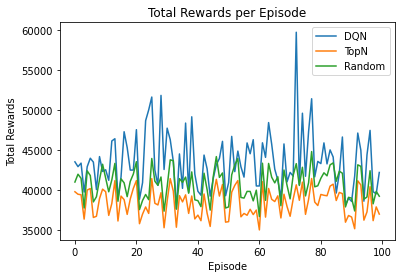

In [52]:
plot_arr([model_name, 'TopN', 'Random'], [model_total_rewards, topN_total_rewards, random_total_rewards], 'Total Rewards')

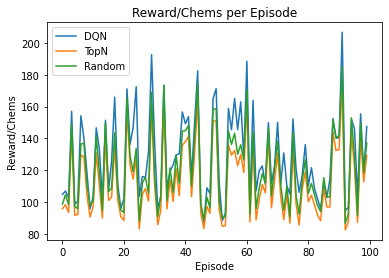

In [53]:
plot_arr([model_name, 'TopN', 'Random'], [model_reward_per_chems, topN_reward_per_chems, random_reward_per_chems], 'Reward/Chems')

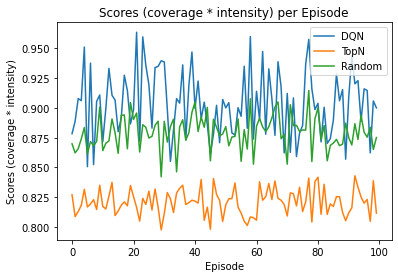

In [72]:
score_type = 'both'
model_scores = get_scores(model_env_list, type=score_type)
topN_scores = get_scores(topN_env_list, type=score_type)
random_scores = get_scores(random_env_list, type=score_type)
plot_arr([model_name, 'TopN', 'Random'], [model_scores, topN_scores, random_scores], 'Scores (coverage * intensity)')

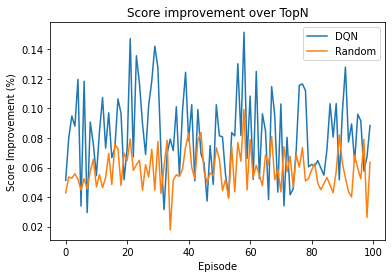

In [66]:
plot_diff([model_name, 'Random'], [model_scores, random_scores], 'TopN', topN_scores)